In [1]:
from dotenv import load_dotenv
import os

from langchain_core.documents import Document

# Carrega as variáveis do arquivo .env para as variáveis de ambiente do sistema
load_dotenv()

# Pega a chave de API que acabamos de carregar
api_key = os.getenv('GROQ_API_KEY')

# Verifica se a chave foi realmente encontrada para evitar erros futuros
if api_key is None:
    raise ValueError("Chave de API GROQ_API_KEY não encontrada. Verifique se o arquivo .env está correto.")

print("Chave de API carregada com sucesso!")

Chave de API carregada com sucesso!


In [2]:
from langchain_groq import ChatGroq
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image
from langchain_core.messages import HumanMessage

In [3]:
llm = ChatGroq(model='llama-3.3-70b-versatile')
embed_model = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [4]:
def carrega_pdf(url: str):
  """Carrega um PDF de uma URL e cria um vetor store em memória."""
  loader = PyPDFLoader(url)
  pages = loader.load()
  vectorstore = InMemoryVectorStore.from_documents(pages, embed_model)
  return vectorstore

In [5]:
print("Criando base de conhecimento da NASA...")
url_nasa = 'https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/m2m_strategy_and_objectives_development.pdf'
vector_store_nasa = carrega_pdf(url_nasa)

print("Criando base de conhecimento sobre Agricultura...")
url_agriculture = 'https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/agriculture.pdf'
vector_store_agriculture = carrega_pdf(url_agriculture)

print("Criando base de conhecimento sobre Dengue...")
url_dengue = 'https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/dengue.pdf'
vector_store_dengue = carrega_pdf(url_dengue)

print("Bases de conhecimento criadas com sucesso!")

Criando base de conhecimento da NASA...
Criando base de conhecimento sobre Agricultura...
Criando base de conhecimento sobre Dengue...
Bases de conhecimento criadas com sucesso!


In [6]:
@tool
def pega_contexto_nasa(query: str) -> list[Document]:
  """Pega o contexto sobre NASA e viagens espaciais baseado numa pesquisa."""
  retriever = vector_store_nasa.as_retriever()
  resultado = retriever.invoke(query)
  return resultado

@tool
def pega_contexto_agriculture(query: str) -> list[Document]:
  """Pega o contexto sobre agricultura baseado numa pesquisa."""
  retriever = vector_store_agriculture.as_retriever()
  resultado = retriever.invoke(query)
  return resultado

@tool
def pega_contexto_dengue(query: str) -> list[Document]:
  """Pega o contexto sobre dengue baseado numa pesquisa."""
  retriever = vector_store_dengue.as_retriever()
  resultado = retriever.invoke(query)
  return resultado

tools = [pega_contexto_nasa, pega_contexto_agriculture, pega_contexto_dengue]

In [7]:
system_prompt = """Você é um assistente prestativo que apenas fornece respostas baseadas no contexto fornecido. Se a resposta não estiver no contexto, diga "Não sei".

IMPORTANTE: Você deve analisar a pergunta do usuário e escolher a ferramenta apropriada:
- pega_contexto_nasa: Use para perguntas sobre a NASA, viagens espaciais, exploração de Marte, objetivos espaciais.
- pega_contexto_agriculture: Use para perguntas sobre agricultura, fazendas, economia agrícola, agricultura da Índia.
- pega_contexto_dengue: Use para perguntas sobre dengue, doenças, saúde.

Sempre use pelo menos uma ferramenta antes de responder. Baseie sua resposta apenas no contexto recuperado.
"""

In [8]:
memoria = MemorySaver()
app = create_react_agent(model=llm, tools=tools, prompt=system_prompt, checkpointer=memoria)

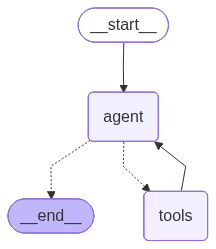

In [9]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    print("Para visualizar o grafo, instale o pygraphviz: uv pip install pygraphviz")

In [10]:
def chat_com_agente(mensagem_usuario: str, thread_id: str):
    config = {"configurable": {"thread_id": thread_id}}
    messages = app.invoke({'messages': [HumanMessage(content=mensagem_usuario)]}, config)
    # A resposta final do assistente é a última mensagem na lista
    resposta_final = messages['messages'][-1]
    return resposta_final.content

In [11]:
resposta = chat_com_agente(
    mensagem_usuario="What are the Objectives Development Process in NASA's document?",
    thread_id="thread-nasa"
)
print(f"Resposta da IA: {resposta}")

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01jjmt677pf1za4rxe4spv07rr` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99928, Requested 192. Please try again in 1m43.004s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
resposta = chat_com_agente(
    mensagem_usuario="what causes dengue?",
    thread_id="thread-dengue"
)
print(f"Resposta da IA: {resposta}")

In [ ]:
resposta = chat_com_agente(
    mensagem_usuario="And what about the number of cases?",
    thread_id="thread-dengue"
)
print(f"Resposta da IA: {resposta}")